# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 21: Constraints on Return and Risk Measures

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2020-01-01'
end = '2023-01-01'

# # Tickers of assets
# assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
#           'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
#           'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets = ['AAPL','PEP','JNJ','TSLA','BA']
assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  5 of 5 completed


In [2]:
# Calculating returns

Y = data[assets].pct_change().dropna()

display(Y.head())

,AAPL,BA,JNJ,PEP,TSLA
Date,,,,,
2020-01-03,-0.9722%,-0.1680%,-1.1578%,-0.1399%,2.9633%
2020-01-06,0.7968%,0.2945%,-0.1247%,0.3834%,1.9255%
2020-01-07,-0.4703%,1.0607%,0.6107%,-1.5718%,3.8801%
2020-01-08,1.6086%,-1.7523%,-0.0138%,0.5149%,4.9205%
2020-01-09,2.1241%,1.4998%,0.2966%,0.0668%,-2.1945%


## 2. Estimating Mean Variance Portfolios

### 2.1 Calculating the portfolio that maximizes Sharpe ratio.

In [17]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AAPL,BA,JNJ,PEP,TSLA
weights,0.0000%,0.0000%,33.0415%,26.7766%,40.1819%


In [19]:
w

,weights
AAPL,0.0000%
BA,0.0000%
JNJ,33.0415%
PEP,26.7766%
TSLA,40.1819%


### 2.2 Plotting portfolio composition

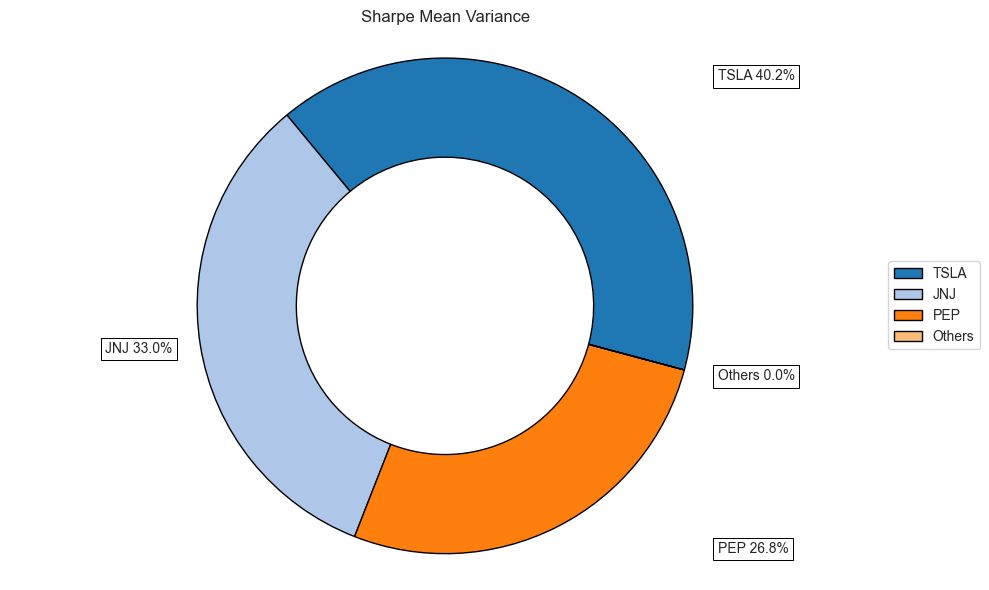

In [4]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 2.3 Calculate Efficient Frontier

In [6]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AAPL,BA,JNJ,PEP,TSLA
0,0.0000%,0.0000%,73.1587%,23.2733%,3.5680%
1,0.0000%,0.0000%,63.0727%,24.1537%,12.7736%
2,0.0000%,0.0000%,58.7241%,24.5337%,16.7422%
3,0.0000%,0.0000%,55.2756%,24.8327%,19.8917%
4,0.0000%,0.0000%,52.2720%,25.0957%,22.6322%


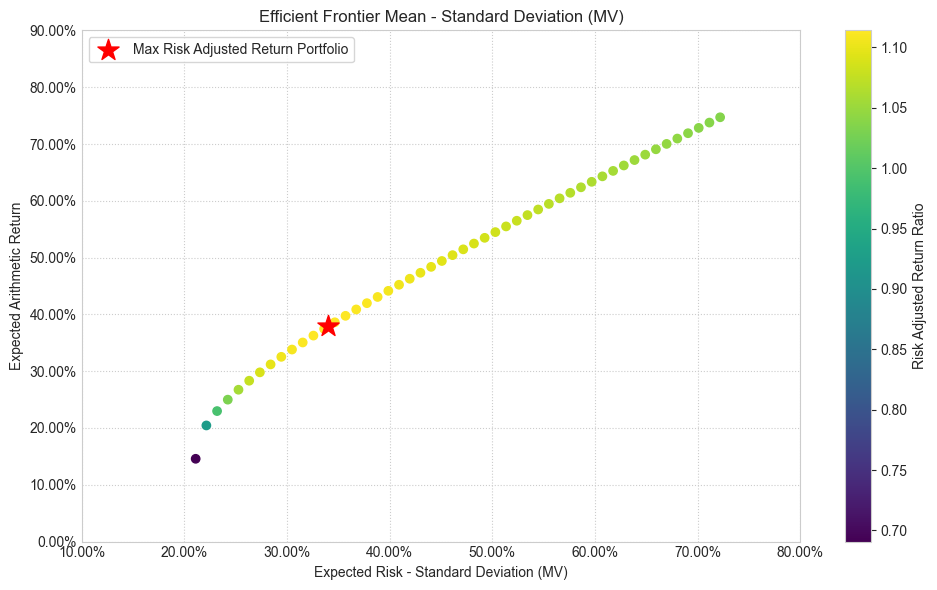

In [7]:
# Plotting the efficient frontier in Std. Dev. dimension

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

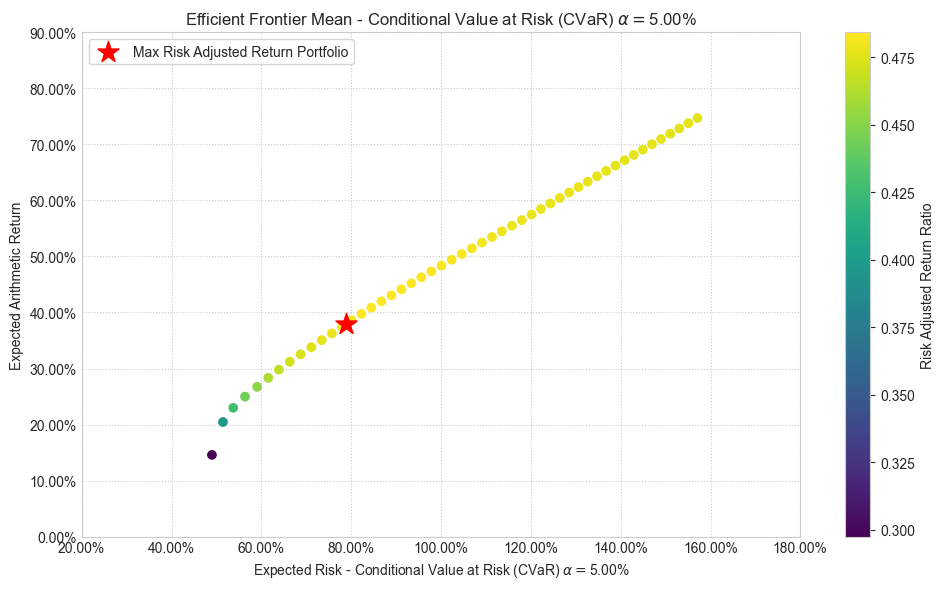

In [8]:
# Plotting the efficient frontier in CVaR dimension

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm='CVaR',
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

We can see that in this case, the efficient frontier made using mean-variance optimization has a similar form when we plot it using CVaR as risk measure.

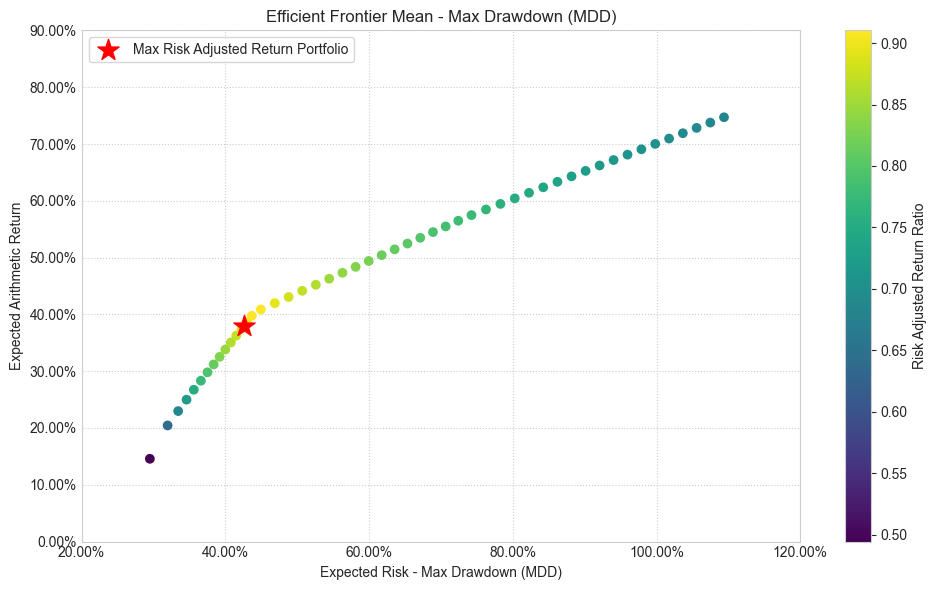

In [9]:
# Plotting the efficient frontier in Max Drawdown dimension

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm='MDD',
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

We can see that in this case, the efficient frontier made using mean-variance optimization looks like a snake when  we plot it using Max Drawdown as risk measure.

## 3. Building Portfolios with Constraints on Return and Risk Measures

### 3.1 Estimating Risk Limits for the Available Set of Assets

This is the first step, we are going to estimate the min and max values for each risk measures. I recommend this step because in large scale problems is not practical to build the entire efficient frontier, it is faster to find the first and last point of the frontier for each risk measure. Using this portfolios we can find the lowest and higher values for each risk measure that we can obtained with the available set of assets.

In [10]:
risk = ['MV', 'CVaR', 'MDD']
label = ['Std. Dev.', 'CVaR', 'Max Drawdown']
alpha = 0.05

for i in range(3):
    limits = port.frontier_limits(model=model, rm=risk[i], rf=rf, hist=hist)
    risk_min = rp.Sharpe_Risk(limits['w_min'], cov=cov, returns=returns, rm=risk[i], rf=rf, alpha=alpha)
    risk_max = rp.Sharpe_Risk(limits['w_max'], cov=cov, returns=returns, rm=risk[i], rf=rf, alpha=alpha)    

    if 'Drawdown' in label[i]:
        factor = 1    
    else:
        factor = 252**0.5

    print('\nMin Return ' + label[i] + ': ', (mu @ limits['w_min']).item() * 252)
    print('Max Return ' + label[i] + ': ',  (mu @ limits['w_max']).item() * 252)
    print('Min ' + label[i] + ': ', risk_min * factor)
    print('Max ' + label[i] + ': ', risk_max * factor)


Min Return Std. Dev.:  0.1457746219288209
Max Return Std. Dev.:  0.7470637721332382
Min Std. Dev.:  0.21104574641793322
Max Std. Dev.:  0.7218818160906421

Min Return CVaR:  0.1352249342093233
Max Return CVaR:  0.747063772172932
Min CVaR:  0.48930032999432443
Max CVaR:  1.5709988703534818

Min Return Max Drawdown:  0.14135323172566006
Max Return Max Drawdown:  0.7470637719443524
Min Max Drawdown:  0.28117792927259866
Max Max Drawdown:  1.0937887040850383


In [20]:
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
print(w)

      weights
AAPL  0.0000%
BA    0.0000%
JNJ  33.0415%
PEP  26.7766%
TSLA 40.1819%


We can see from the above information, that if our objective function uses Std. Dev. as risk measure, we only can obtain returns between 12.85% and 31.17%, and Std. Dev. between 10.37% and 21.92%. The same applies for the other risk measures. This is very useful because if we put a constraint on max CVaR below 23.75% the optimization problem doesn't have a solution.

### 3.2 Calculating the portfolio that maximizes Sharpe ratio with constraints in Return, CVaR and Max Drawdown.

In [46]:
rm = 'MV' # Risk measure

# Constraint on minimum Return
port.lowerret = 0.16/252  # We transform annual return to daily return

# Constraint on maximum CVaR
port.upperCVaR = 0.76/252**0.5 # We transform annual CVaR to daily CVaR

# Constraint on maximum Max Drawdown
port.uppermdd = 0.56  # We don't need to transform drawdowns risk measures

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,AAPL,BA,JNJ,PEP,TSLA
weights,0.0000%,0.0000%,36.4254%,25.6382%,37.9364%


### 3.3 Plotting portfolio composition

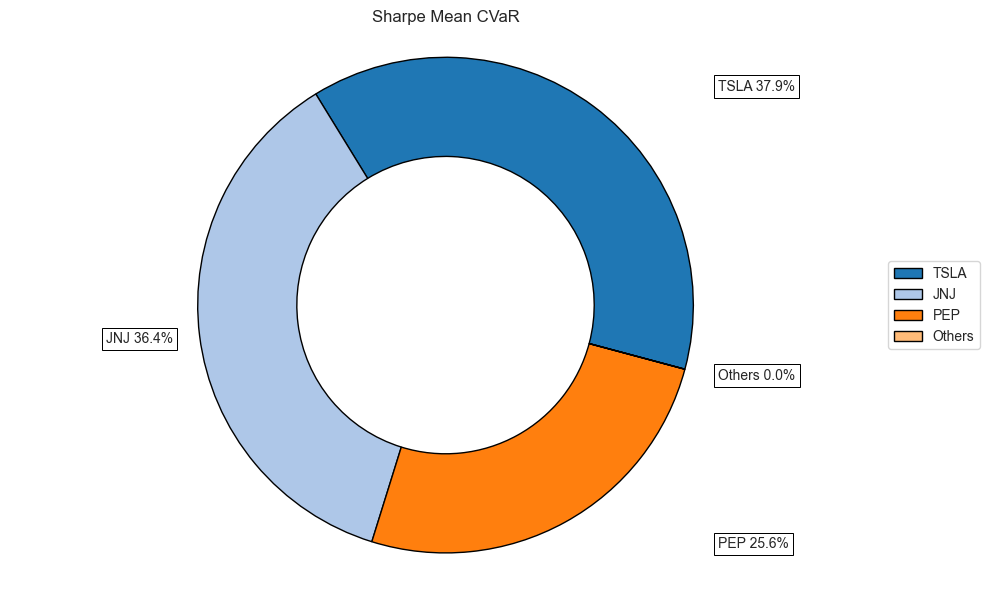

In [47]:
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 3.4 Calculate Efficient Frontier

In [48]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AAPL,BA,JNJ,PEP,TSLA
0,0.0000%,0.0000%,70.7146%,23.4869%,5.7985%
1,0.0000%,0.0000%,67.6114%,23.7578%,8.6308%
2,0.0000%,0.0000%,65.6841%,23.9261%,10.3898%
3,0.0000%,0.0000%,64.1441%,24.0605%,11.7954%
4,0.0000%,0.0000%,62.8166%,24.1764%,13.0070%


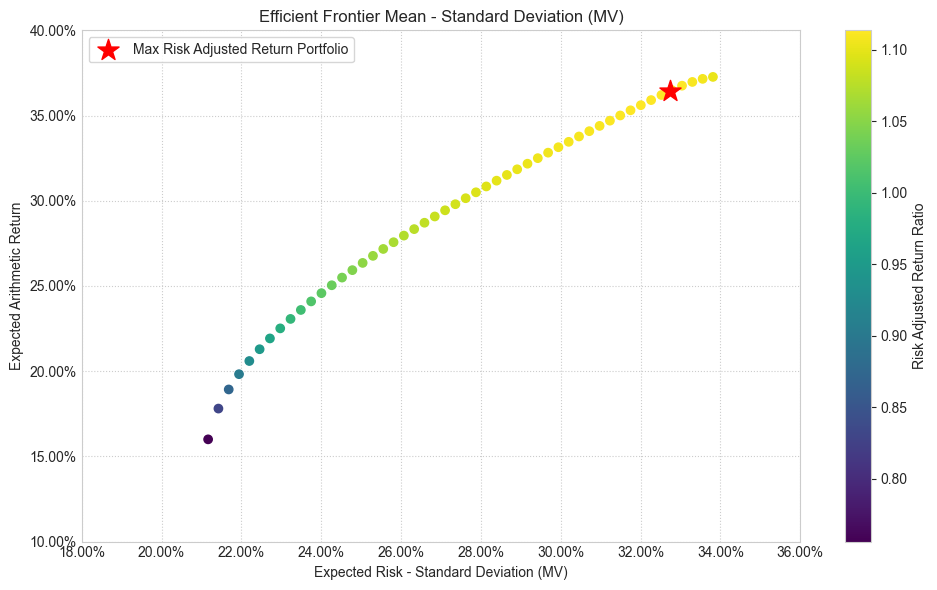

In [49]:
# Plotting the efficient frontier in Std. Dev. dimension

label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

We can see that the new efficient frontier has a lower bound on returns of 16%.

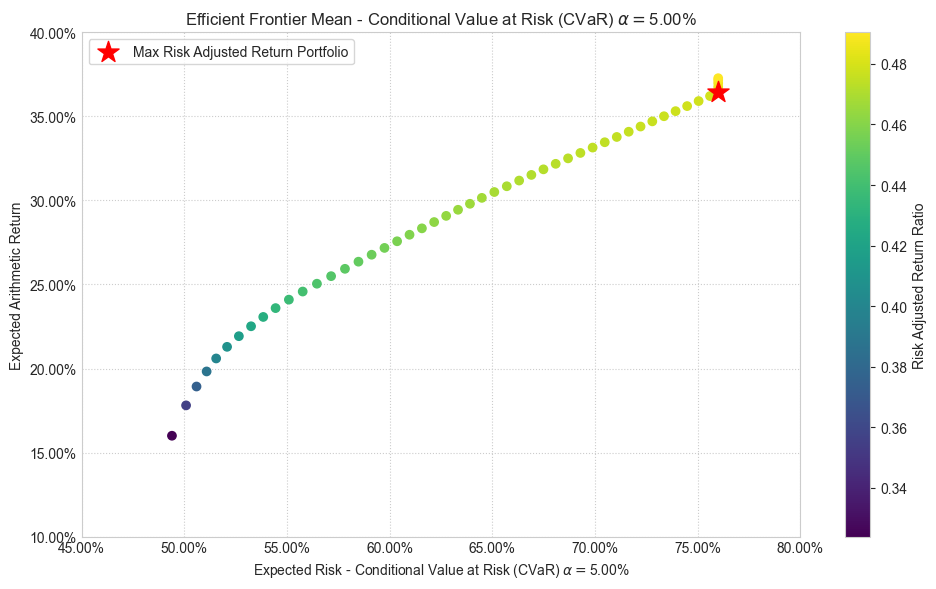

In [50]:
# Plotting the efficient frontier in CVaR dimension

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm='CVaR',
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

We can see that the new efficient frontier has a upper bound on CVaR of 26%.

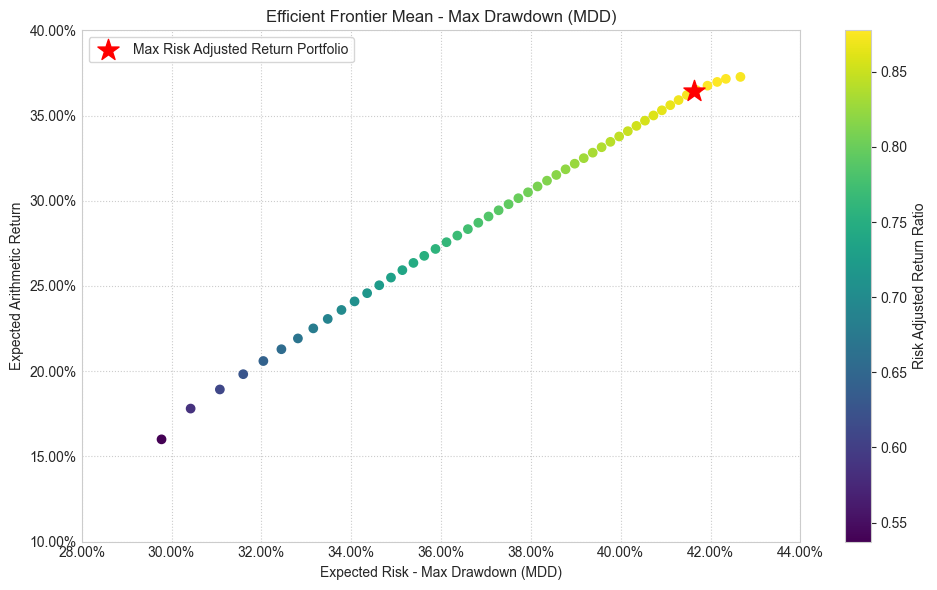

In [51]:
# Plotting the efficient frontier in Max Drawdown dimension

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm='MDD',
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

We can see that the new efficient frontier has a upper bound on Max Drawdown of 13.1%.